# 💫 套件 & 資料讀取

In [1]:
# 套件
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

# 圖表字型設定
plt.rcParams['font.family'] = ['Microsoft JhengHei', 'sans-serif']


In [2]:
# 資料讀取
df_purchase = pd.read_csv('full_data.csv')
df_customer = pd.read_json('customer_data.json')

# 合併兩筆資料
df_merged = pd.merge(df_purchase, df_customer, on='CustomerID', how='left')

# ❓題目一：基礎分析
情境： 你剛剛加入一家公司，負責分析他們的客戶購買行為以改進營銷策略。

Question： 請列出目前客戶資料中最受歡迎的五個產品是哪些？這些產品的銷售量和總銷售金額各是多少？

提示： 使用客戶資料和產品資料進行合併，計算每個產品的銷售量和總銷售金額。

## 📝 第一題作答

#### 最受歡迎定義：

1. 最多人曾經購買過
    => 最能吸引不同客人的能力
2. 總銷量第一
    => 需求量最高

#### 邏輯

1. 求出每個產品曾被哪些顧客買過
2. 求出每個產品在 2020/01 到 2024/06 間的總銷量
3. 金額跟單價掛勾，與受歡迎程度較無直接性相關，因此不做為排名的考慮因素

#### 結果

1. 每個產品皆被所有顧客(各十人)購買過
    => 吸引力沒有差異性
2. 銷售量最高前五如下表格(含總銷售額):

    | ProductName          | Quantity | TotalPrice |
    |----------------------|----------|------------|
    | AirPods Pro          | 3744 🏆  | 932256     |
    | iPad Pro             | 3687     | 2945913    |
    | iMac                 | 3585     | 4656915 🏆 |
    | Apple Watch Series 7 | 3583     | 1429617    |
    | iPhone 13 Pro Max    | 3582     | 3936618    |

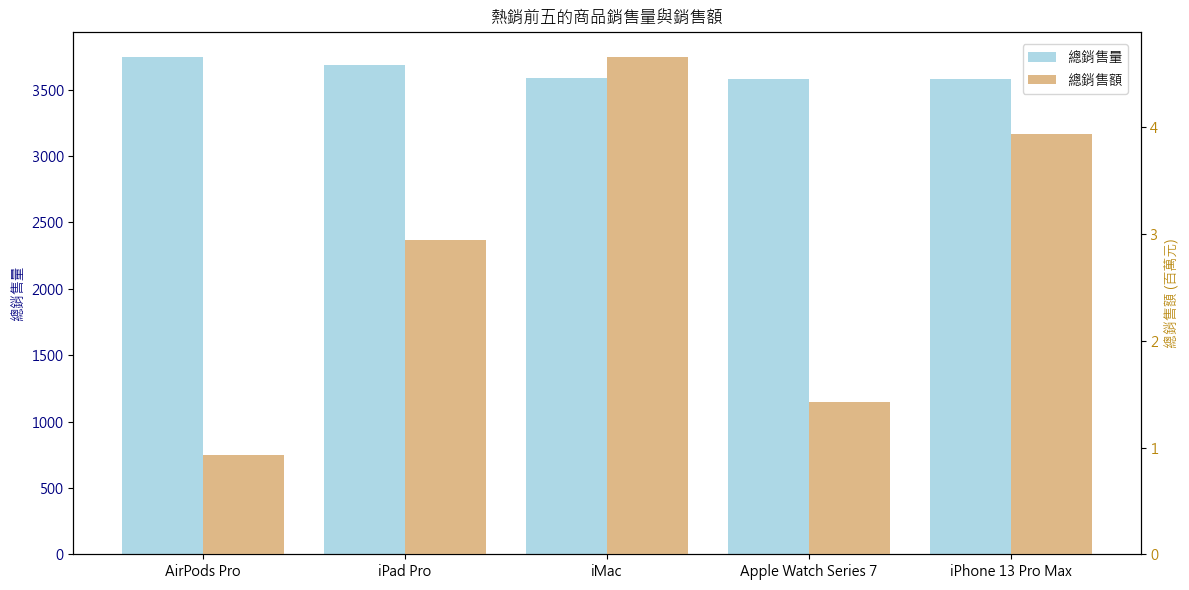


In [3]:
# 熱銷產品前五: 總銷量＋總銷額
df_topSale_5 = df_merged.groupby('ProductName').agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).sort_values(by='Quantity', ascending=False).head(5)

In [4]:
# 計算單產品，被多少不同顧客買過: 人氣指標
df_popularity = df_merged.groupby('ProductName').agg({
    'ScientistName': lambda x: x.nunique(dropna=False)
})

df_popularity.columns = ['UniqueBuyers']

df_popularity.sort_values(by='UniqueBuyers', ascending=False)

,UniqueBuyers
ProductName,
AirPods Pro,10
Apple Watch Series 7,10
HomePod mini,10
MacBook Air,10
iMac,10
iPad Pro,10
iPhone 13 Pro Max,10


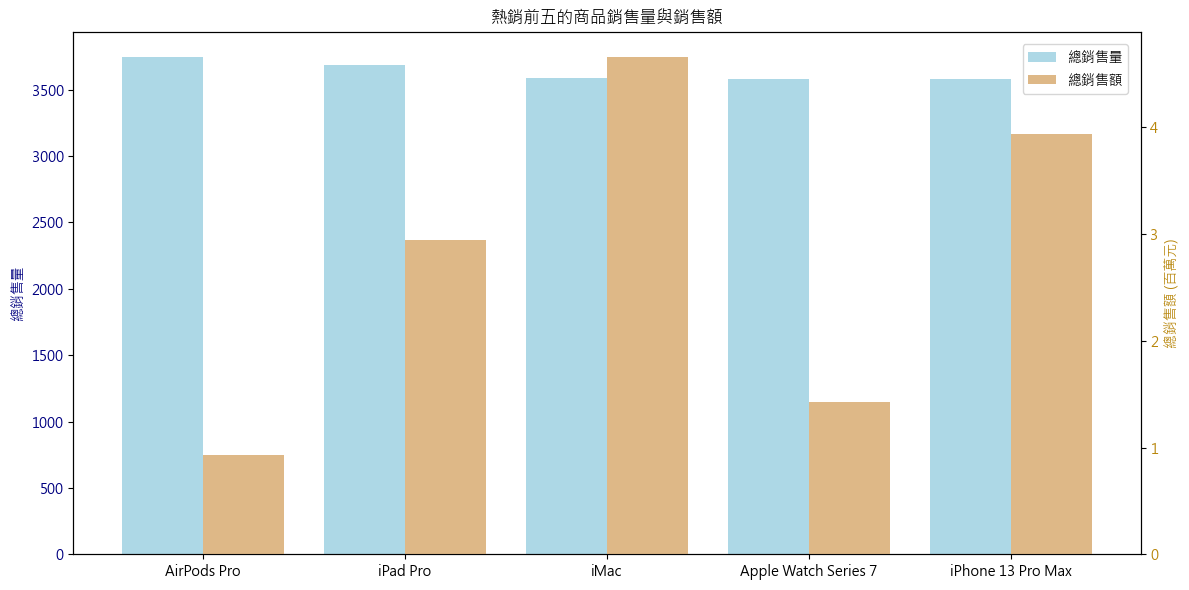

In [5]:
# 雙軸柱狀圖
products = df_topSale_5.index.tolist()
quantity = df_topSale_5['Quantity'].values
total_price = df_topSale_5['TotalPrice'].values

# x 軸座標
x = np.arange(len(products))
width = 0.4

# 建立圖表與雙 Y 軸
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# 左側：總銷售量
bar1 = ax1.bar(x - width/2, quantity, width, color='lightblue', label='總銷售量')
ax1.set_ylabel('總銷售量', color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# 右側：總銷售額 (百萬元)
bar2 = ax2.bar(x + width/2, total_price/1000000, width, color='burlywood', label='總銷售額')
ax2.set_ylabel('總銷售額 (百萬元)', color='darkgoldenrod')
ax2.tick_params(axis='y', labelcolor='darkgoldenrod')

# x 軸設定
plt.xticks(x, products, rotation=0, ha='right')
plt.title('熱銷前五的商品銷售量與銷售額')

# 加入圖例（放在上方右側）
fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.93))

# 自動調整圖表的排版與元件間距
fig.tight_layout()
plt.show()

# ❓題目二：客戶分群分析
情境： 公司想要了解客戶的消費習慣，以便設計針對性的行銷活動。

Question： 請對客戶進行分群，基於他們的購買頻率和總購買金額，分析出至少三個不同的客戶群體。每個群體中客戶的特徵和購買行為有何不同？

提示： 使用客戶資料計算每個客戶的購買頻率和總購買金額，再根據這些指標進行客戶分群。

## 📝 第二題作答

### 定義購買頻率與行為
1. 頻率：客戶在 2020/01 到 2024/06 間，四年半內來訪購物的次數。<br>
2. 行為：在各自的消費頻率下，所累積的消費金額，代表各自的消費行為能力與需求。

### 客群特徵行為分類
1. 高購買力<br> 
    a. 特徵: 消費總額超過 180 萬，次數超過 1010 次。<br>
    b. 行為: 頻率高同時消費金額高時，表示高度需求與依賴度，屬於高消費力族群。<br>
    <br>
2. 中購買力<br>
    a. 特徵: 消費總額介於 180 至 170 萬，次數介於 1010 至 985 次。<br>
    b. 行為: 屬於中等頻率與消費額，穩定有成長空間，屬於中消費力族群。<br>
    <br>
3. 低購買力<br>
    a. 特徵: 消費總額超過 180 萬，次數超過 1010 次。<br>
    b. 行為: 消費金額與次數相較下偏低，表示低需求與依賴度，屬於低消費力族群。<br>

### 邏輯
1. 計算每個客戶在 2020/01 到 2024/06 間的以下數據: <br>
    a. 總購買次數<br>
    b. 總消費金額<br>
    <br>
2. 使用 K‑Means 聚類法: <br>
    將資料根據多個變數（特徵）自動分 3 個群，讓同群內的資料距離最近（平均誤差最低），而不同群之間差異最大。

### 結果
| ScientistName       | PurchaseCount | TotalSpending | ClusterLabel |
|---------------------|----------------|----------------|----------------|
| 奇努·撲敵客         | 1045           | 1931334        | 高消費力       |
| 小傑·富力士         | 1065           | 1864409        | 高消費力       |
| 酷拉皮卡             | 1030           | 1843645        | 高消費力       |
| 西索                 | 995            | 1789480        | 中消費力       |
| 伊耳謎·撲敵客       | 985            | 1776652        | 中消費力       |
| 庫洛洛·魯西魯       | 988            | 1765483        | 中消費力       |
| 雷歐力·帕拉丁奈特   | 1009           | 1736768        | 中消費力       |
| 尼特羅               | 984            | 1663912        | 低消費力       |
| 凱特                 | 931            | 1652875        | 低消費力       |
| 金富力士             | 968            | 1630211        | 低消費力       |


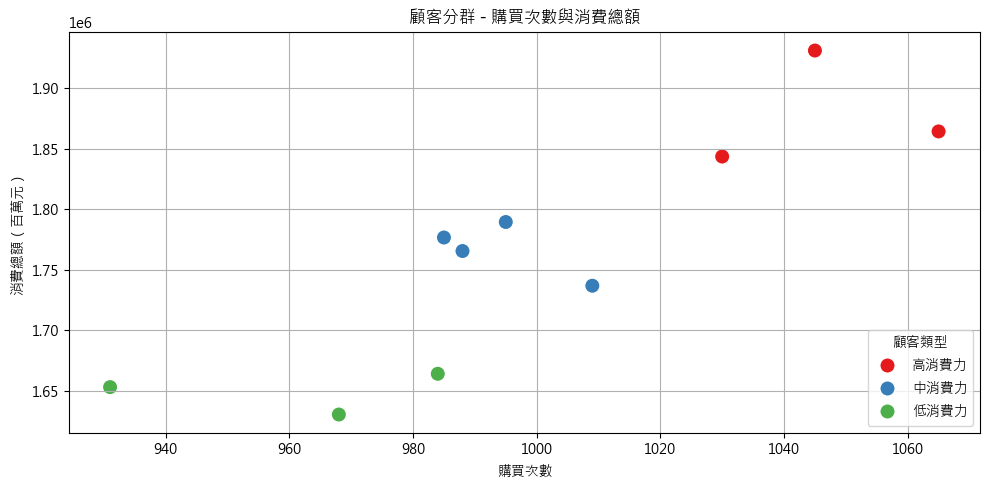

In [6]:
df_customerSpend = df_merged.groupby('ScientistName').agg(
    PurchaseCount=('PurchaseDate', 'count'),
    TotalSpending=('TotalPrice', 'sum')
).sort_values(by='TotalSpending', ascending=False)

In [7]:
# 特徵標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_customerSpend[['PurchaseCount', 'TotalSpending']])

# 訓練 KMeans 模型
kmeans = KMeans(n_clusters=3, random_state=42)

# 建立分群結果
df_customerSpend['Cluster'] = kmeans.fit_predict(X_scaled)

In [8]:
# 建立自訂的顏色對應
label_map = {
    0: '中消費力',
    1: '低消費力',
    2: '高消費力'
}

# 替換 Cluster 數字為文字
df_customerSpend['ClusterLabel'] = df_customerSpend['Cluster'].map(label_map)

df_customerSpend[['PurchaseCount', 'TotalSpending', 'ClusterLabel']].sort_values(
    by=['TotalSpending', 'ClusterLabel'], ascending=False
)

,PurchaseCount,TotalSpending,ClusterLabel
ScientistName,,,
奇犽·揍敵客,1045,1931334.0,高消費力
小傑·富力士,1065,1864409.0,高消費力
酷拉皮卡,1030,1843645.0,高消費力
西索,995,1789480.0,中消費力
伊耳謎·揍敵客,985,1776652.0,中消費力
庫洛洛·魯西魯,988,1765483.0,中消費力
雷歐力·帕拉丁奈特,1009,1736768.0,中消費力
尼特羅,984,1663912.0,低消費力
凱特,931,1652875.0,低消費力


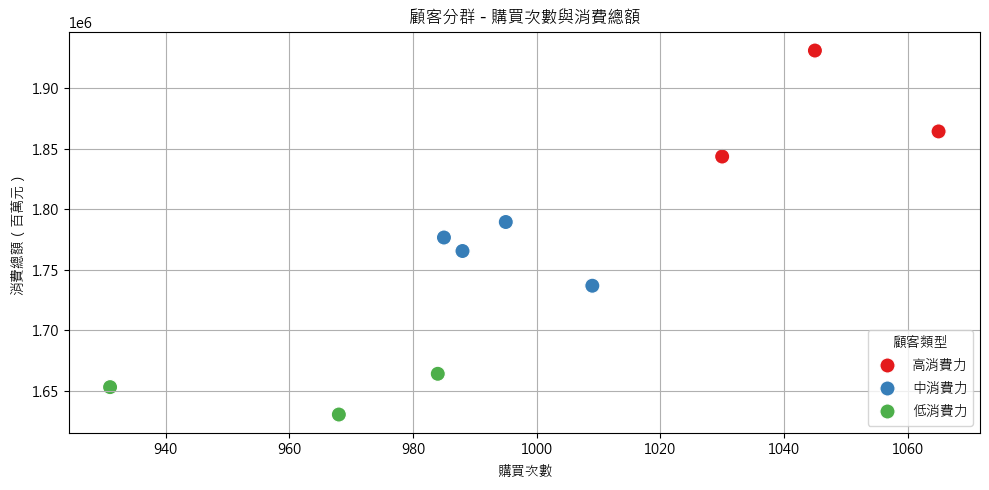

In [9]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_customerSpend, x='PurchaseCount', y='TotalSpending',
                hue=df_customerSpend['Cluster'].map(label_map),
                palette='Set1', s=120)

plt.title('顧客分群 - 購買次數與消費總額')
plt.xlabel('購買次數')
plt.ylabel('消費總額（百萬元）')
plt.legend(title='顧客類型', loc = 'lower right') 
plt.grid(True)
plt.tight_layout()
plt.show()

# ❓題目三：產品分析
情境： 公司希望了解不同類型產品的銷售情況，以評估市場需求。

Question： 請分析每個產品類別的銷售量和銷售金額占比。哪些產品類別是銷售的主要貢獻者？是否有某些產品類別的銷售表現較差，需要進行改進？

提示： 使用產品資料進行分析，計算每個產品類別的銷售量和銷售金額，再計算其占比。


## 📝 第三題作答
### 定義主要貢獻
1. 銷售量占比最高的產品 => 帶給公司最多利潤。
2. 銷售總量占比最高的產品 => 帶給公司最多曝光度。

### 定義銷售表現
銷售的數量越高銷售表現越好

### 邏輯
1. 計算各個產品的總銷量與總銷售金額 <br>
2. 計算各個產品在總銷量與總銷售金額的占比

### 結果
1. 主要貢獻者:<br>
    a. 利潤最高者：Desktop <br>
    b. 銷售量最多者：宏觀是平均的，但最高是 Headphones<br>
    <br>
2. 表現較差: Smart Speaker

| Category | TotalQuantity | TotalRevenue | QuantityShare | RevenueShare |
| --- | --- | --- | --- | --- |
| Desktop | 3585 | 4656915 | 0.143 | 0.264 🏆 |
| Headphones | 3744 | 932256 | 0.150 🏆 | 0.053 |
| Laptop | 3417 | 3413583 | 0.137 ⚠️ | 0.193 |
| Smart Speaker | 3433 | 339867 | 0.137 ⚠️ | 0.019 ⚠️ |
| Smartphone | 3582 | 3936618 | 0.143 | 0.223 |
| Tablet | 3687 | 2945913 | 0.147 | 0.167 |
| Wearable | 3583 | 1429617 | 0.143 | 0.081 |

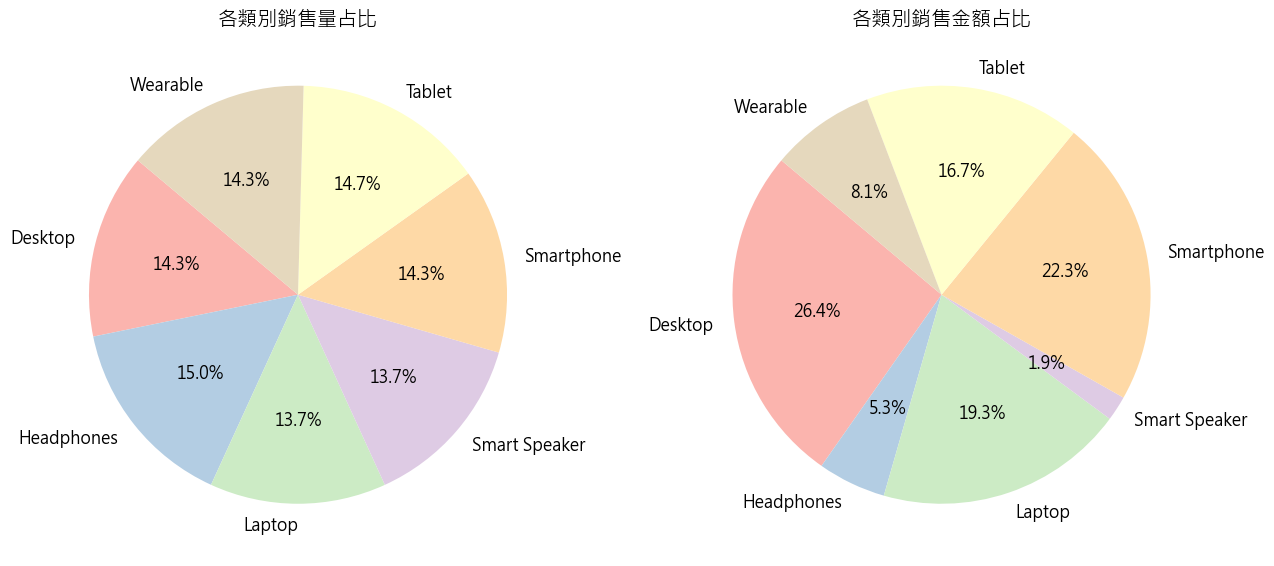

In [10]:
# 總銷售量+總銷售金額
df_purchase['TotalPrice'] = df_purchase['Quantity'] * df_purchase['Price']

df_category = df_purchase.groupby('Category').agg(
    TotalQuantity=('Quantity', 'sum'),
    TotalRevenue=('TotalPrice', 'sum')
).reset_index()

# 銷售量與金額占比
df_category['QuantityShare'] = df_category['TotalQuantity'] / df_category['TotalQuantity'].sum()
df_category['RevenueShare'] = df_category['TotalRevenue'] / df_category['TotalRevenue'].sum()

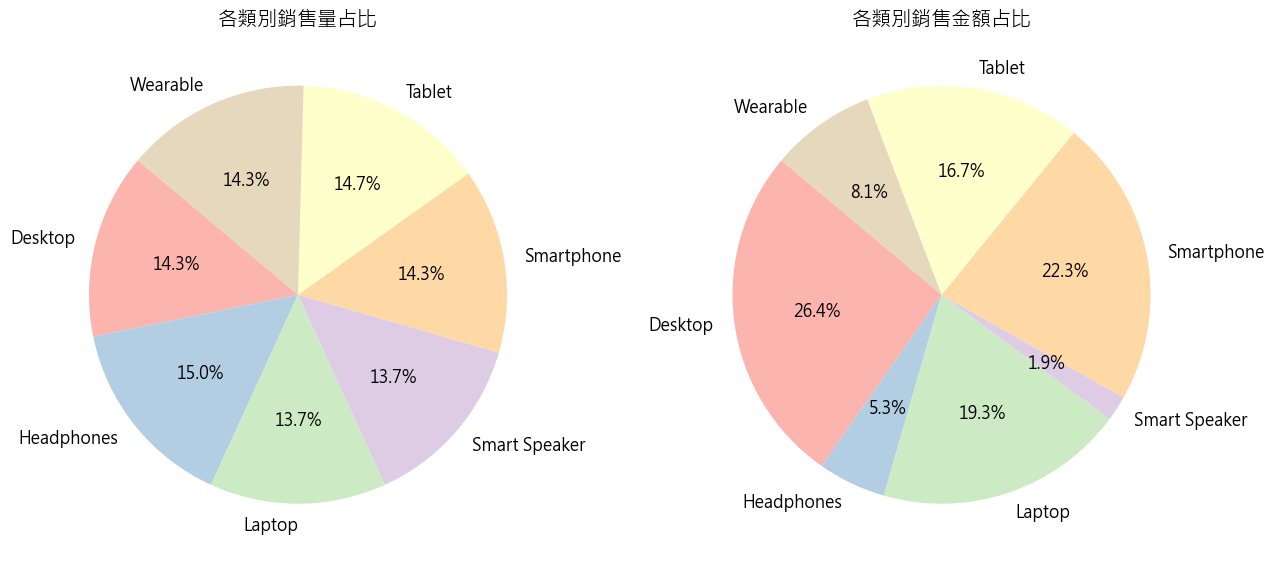

In [11]:
# 設定圖表字體大小
plt.rcParams.update({'font.size': 12})

# 建立 1x2 子圖畫布
fig, axes = plt.subplots(1, 2, figsize=(13, 7))

# 🎯 銷售量占比圓餅圖
axes[0].pie(df_category['TotalQuantity'],
            labels=df_category['Category'],
            autopct='%1.1f%%',
            startangle=140,
            colors=plt.cm.Pastel1.colors)
axes[0].set_title('各類別銷售量占比')

# 🎯 銷售金額占比圓餅圖
axes[1].pie(df_category['TotalRevenue'],
            labels=df_category['Category'],
            autopct='%1.1f%%',
            startangle=140,
            colors=plt.cm.Pastel1.colors)
axes[1].set_title('各類別銷售金額占比')

plt.tight_layout()
plt.show()

# ❓題目四：客戶忠誠度分析
情境： 公司希望了解客戶的忠誠度和購買趨勢，以保持現有客戶和吸引新客戶。

Question： 請分析客戶的購買頻率和購買金額的分佈情況。哪些客戶是公司的忠實顧客？有沒有具有潛力的新客戶？

提示： 使用客戶資料計算每個客戶的購買頻率和購買金額，進行客戶忠誠度的分析。

橫跨2020-2024年

## 📝 第四題作答

### 定義忠誠度與潛力
1. 忠誠度<br>
    購買頻率越高忠誠度越高，表示依賴程度高！<br><br>
2. 潛力<br>
    綜合消費金額與購買頻率成長狀況，分成 1 , 0, -1 <br>

    | potential 值 | 定義說明                           |
    |--------------|--------------|
    | 1            | 正在穩定成長（次數與金額都上升）     |
    | 0            | 部分成長（次數或金額其中之一成長）   |
    | -1           | 全面下滑（次數與金額都下滑）        |

### 邏輯

1. 針對每位顧客，計算最早與最晚購買日 + 購買次數
2. 計算總天數區間與平均間隔
3. 以「年」為單位
4. 計算每位顧客每年的購買次數與總金額
5. 移除 2024 年 => 資料不滿一年
6. 做線性回歸 LinearRegression：計算出金額趨勢、次數趨勢，大於 0 為成長，反之負成長。

### 結果

#### 忠誠度

| ScientistName | FirstVisit | LastVisit | VisitCount | DaysRange | AvgDaysPerVisit |
| --- | --- | --- | --- | --- | --- |
| 小傑·富力士 | 2020-01-01 | 2024-05-30 | 1065 | 1611 | 1.51 |
| 奇犽·揍敵客 | 2020-01-01 | 2024-05-29 | 1045 | 1610 | 1.54 |
| 酷拉皮卡 | 2020-01-03 | 2024-06-01 | 1030 | 1611 | 1.57 |
| 雷歐力·帕拉丁奈特 | 2020-01-01 | 2024-06-01 | 1009 | 1613 | 1.60 |
| 西索 | 2020-01-01 | 2024-06-01 | 995 | 1613 | 1.62 |
| 庫洛洛·魯西魯 | 2020-01-03 | 2024-05-31 | 988 | 1610 | 1.63 |
| 伊耳謎·揍敵客 | 2020-01-02 | 2024-06-01 | 985 | 1612 | 1.64 |
| 尼特羅 | 2020-01-01 | 2024-05-30 | 984 | 1611 | 1.64 |
| 金·富力士 | 2020-01-04 | 2024-06-01 | 968 | 1610 | 1.66 |
| 凱特 | 2020-01-02 | 2024-06-01 | 931 | 1612 | 1.73 🏆|

#### 潛力


| ScientistName | AmountTrend | CountTrend | potential |
| --- | --- | --- | --- |
| 庫洛洛·魯西魯 | 4136.9 | 4.4 | 1 🏆|
| 奇犽·揍敵客 | 3735.3 | 1.0 | 1 🏆|
| 尼特羅 | -678.7 | 4.2 | 0 📈|
| 金·富力士 | -1143.5 | 0.1 | 0 📈|
| 酷拉皮卡 | 6844.7 | -1.9 | 0 📈|
| 小傑·富力士 | -11400.7 | -1.1 | -1 |
| 雷歐力·帕拉丁奈特 | -15606.5 | -2.0 | -1 |
| 西索 | -1637.9 | -3.0 | -1 |
| 凱特 | -12118.9 | -4.4 | -1 |
| 伊耳謎·揍敵客 | -12867.3 | -4.6 | -1 |


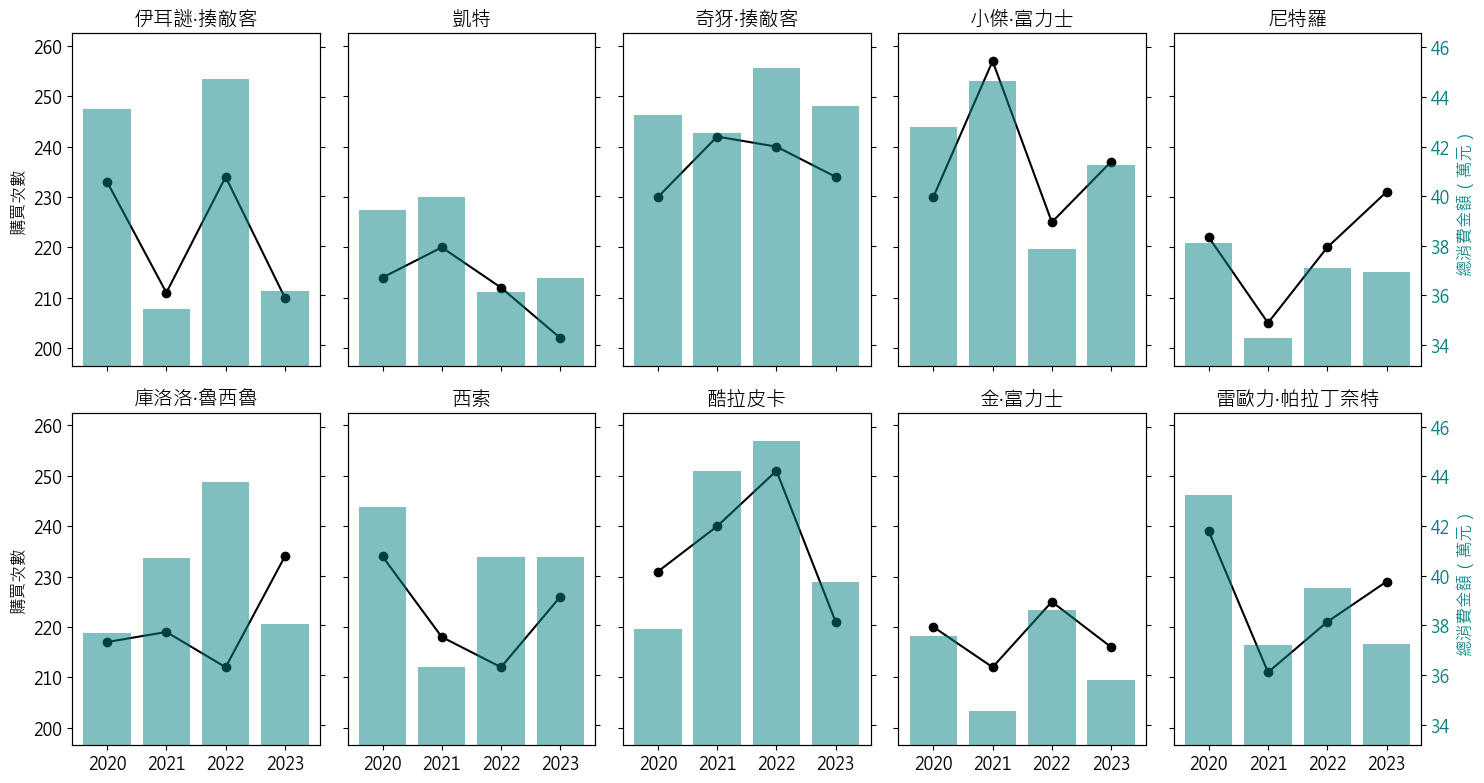

In [12]:
# 確保日期正確
df_merged['PurchaseDate'] = pd.to_datetime(df_merged['PurchaseDate'])

# 針對每位顧客，計算最早與最晚購買日 + 購買次數
df_visit_gap = df_merged.groupby('ScientistName').agg(
    FirstVisit=('PurchaseDate', 'min'),
    LastVisit=('PurchaseDate', 'max'),
    VisitCount=('PurchaseDate', 'count')
).reset_index()

# 計算總天數區間與平均間隔
df_visit_gap['DaysRange'] = (df_visit_gap['LastVisit'] - df_visit_gap['FirstVisit']).dt.days
df_visit_gap['AvgDaysPerVisit'] = df_visit_gap['DaysRange'] / (df_visit_gap['VisitCount'] - 1)

df_visit_gap.sort_values(by='AvgDaysPerVisit')

,ScientistName,FirstVisit,LastVisit,VisitCount,DaysRange,AvgDaysPerVisit
3,小傑·富力士,2020-01-01,2024-05-30,1065,1611,1.514098
2,奇犽·揍敵客,2020-01-01,2024-05-29,1045,1610,1.542146
7,酷拉皮卡,2020-01-03,2024-06-01,1030,1611,1.565598
9,雷歐力·帕拉丁奈特,2020-01-01,2024-06-01,1009,1613,1.600198
6,西索,2020-01-01,2024-06-01,995,1613,1.622736
5,庫洛洛·魯西魯,2020-01-03,2024-05-31,988,1610,1.631206
0,伊耳謎·揍敵客,2020-01-02,2024-06-01,985,1612,1.638211
4,尼特羅,2020-01-01,2024-05-30,984,1611,1.638861
8,金·富力士,2020-01-04,2024-06-01,968,1610,1.664943
1,凱特,2020-01-02,2024-06-01,931,1612,1.733333


In [13]:
# 新增「年」欄位（格式為 2023）
df_merged['Year'] = df_merged['PurchaseDate'].dt.year

# 移除 2024 年資料
df_filtered = df_merged[df_merged['Year'] < 2024]

# groupby 計算每位顧客每年的購買次數與總金額
df_year = df_filtered.groupby(['ScientistName', 'Year']).agg(
    PurchaseCount=('PurchaseDate', 'count'),
    TotalSpending=('TotalPrice', 'sum')
).reset_index()

In [14]:
customers_status = []

# 對每位顧客做趨勢線分析
for customer in df_year['ScientistName'].unique():
    data = df_year[df_year['ScientistName'] == customer].sort_values('Year')
    
    # X 軸是年份（reshape 成 2D）
    X = data['Year'].values.reshape(-1, 1)
    
    # 分別看金額與次數
    y_amount = data['TotalSpending'].values
    y_count = data['PurchaseCount'].values
    
    # 線性回歸：金額趨勢
    reg_amount = LinearRegression().fit(X, y_amount)
    slope_amount = reg_amount.coef_[0]
    
    # 線性回歸：次數趨勢
    reg_count = LinearRegression().fit(X, y_count)
    slope_count = reg_count.coef_[0]
    
    customers_status.append({
        'ScientistName': customer,
        'AmountTrend': slope_amount,
        'CountTrend': slope_count
    })

# 輸出成長顧客清單
import pandas as pd
df_cStatus = pd.DataFrame(customers_status)
# 新增 loyalty 欄位
df_cStatus['potential'] = df_cStatus.apply(
    lambda row: 1 if row['AmountTrend'] > 0 and row['CountTrend'] > 0
    else 0 if row['AmountTrend'] > 0 or row['CountTrend'] > 0
    else -1,
    axis=1
)

df_cStatus_sorted = df_cStatus.sort_values(by=['potential', 'CountTrend'], ascending=False)
df_cStatus_sorted.reset_index(drop=True, inplace=True)
df_cStatus_sorted

,ScientistName,AmountTrend,CountTrend,potential
0,庫洛洛·魯西魯,4136.9,4.4,1
1,奇犽·揍敵客,3735.3,1.0,1
2,尼特羅,-678.7,4.2,0
3,金·富力士,-1143.5,0.1,0
4,酷拉皮卡,6844.7,-1.9,0
5,小傑·富力士,-11400.7,-1.1,-1
6,雷歐力·帕拉丁奈特,-15606.5,-2.0,-1
7,西索,-1637.9,-3.0,-1
8,凱特,-12118.9,-4.4,-1
9,伊耳謎·揍敵客,-12867.3,-4.6,-1


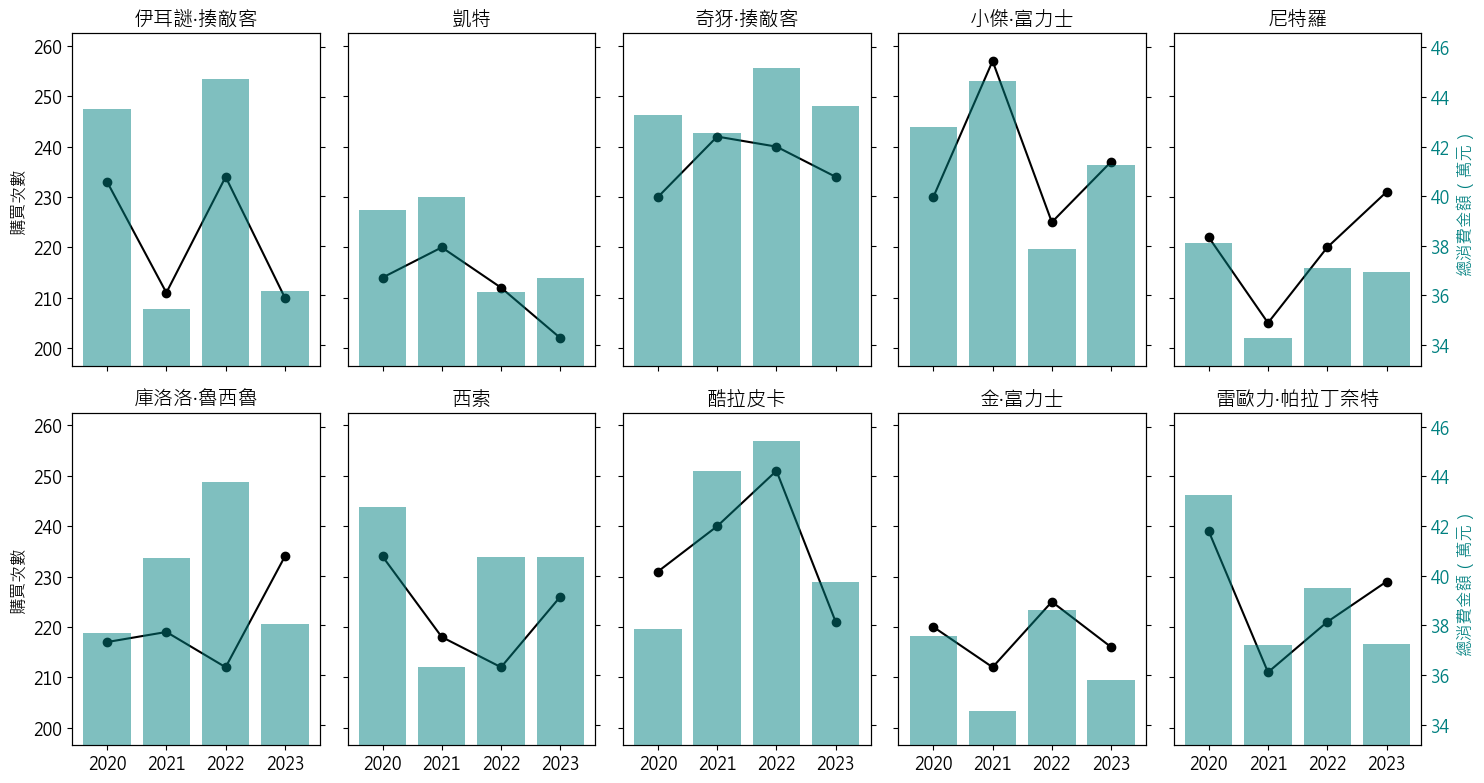

In [15]:
# 將金額轉為萬元單位
df_year['TotalSpending'] = df_year['TotalSpending'] / 10000

# 計算 Y 軸範圍（購買次數 & 金額）
count_min = df_year['PurchaseCount'].min()
count_max = df_year['PurchaseCount'].max()
amount_min = df_year['TotalSpending'].min()
amount_max = df_year['TotalSpending'].max()

# 加入 margin
count_range = count_max - count_min
amount_range = amount_max - amount_min
count_min -= count_range * 0.1
count_max += count_range * 0.1
amount_min -= amount_range * 0.1
amount_max += amount_range * 0.1

# 圖表佈局設定
customers = df_year['ScientistName'].unique()
n_cols = 5
n_rows = -(-len(customers) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharex=True)
axes = axes.flatten()

# 每位顧客一張子圖
for i, customer in enumerate(customers):
    ax1 = axes[i]
    data = df_year[df_year['ScientistName'] == customer]

    # 左軸：購買次數（折線圖）
    ax1.plot(data['Year'], data['PurchaseCount'], color='black', marker='o')
    ax1.set_ylim(count_min, count_max)
    ax1.set_title(customer)
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    # 左側 Y 軸（僅顯示最左側欄）
    if i % n_cols == 0:
        ax1.set_ylabel('購買次數', color='black')
        ax1.tick_params(axis='y', labelcolor='black')
    else:
        ax1.set_yticklabels([])
        ax1.set_ylabel("")

    # 右軸：消費金額（柱狀圖）
    ax2 = ax1.twinx()
    ax2.bar(data['Year'], data['TotalSpending'], color='teal', alpha=0.5)
    ax2.set_ylim(amount_min, amount_max)
    
    # 右側 Y 軸（僅顯示最右側欄）
    if (i + 1) % n_cols == 0:
        ax2.set_ylabel('總消費金額（萬元）', color='teal')
        ax2.tick_params(axis='y', labelcolor='teal')
        ax2.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
        ax2.ticklabel_format(style='plain', axis='y')
    else:
        ax2.set_yticklabels([])
        ax2.set_ylabel("")

plt.tight_layout()
plt.show()

# ❓題目五：預測分析
情境： 公司希望能夠預測未來一段時間內的銷售趨勢，以制定適當的庫存和營銷策略。

Question： 基於目前的客戶購買行為，請預測下個月每個產品的銷售量和銷售金額。你會如何進行這樣的預測分析？

提示： 使用時間序列或機器學習模型來預測下個月的銷售量和銷售金額，可以考慮客戶的購買趨勢和產品的季節性影響。

## 📝 第五題作答
### 思考邏輯

1. 分組統計：每個產品每月的銷售量與銷售金額
2. 踢掉 2024-06 資料
3. 計算出產品每個月的銷售量跟銷售金額
4. 畫出趨勢圖
5. 根據趨勢選用模型建立與訓練（預測銷售量）銷售有穩定趨勢、考慮季節性

### 結果
- 模型選用：<br>
使用 statsmodels.api 的 ols 和 SARIMAX 推估後決定使用 SARIMAX 來做最終結果。<br>

    | ProductName | ForecastMonth | ForecastQuantity | ForecastRevenue |
    | --- | --- | --- | --- |
    | iMac | 2024-06 | 56 | 68271 |
    | AirPods Pro | 2024-06 | 62 | 15152 |
    | MacBook Air | 2024-06 | 62 | 60848 |
    | iPhone 13 Pro Max | 2024-06 | 67 | 78278 |
    | HomePod mini | 2024-06 | 79 | 7514 |
    | Apple Watch Series 7 | 2024-06 | 79 | 31922 |
    | iPad Pro | 2024-06 | 88 | 74777 |


- 理想狀態:<br>
根據每個產品的趨勢，選用不同的模型做各別的預測。<br>
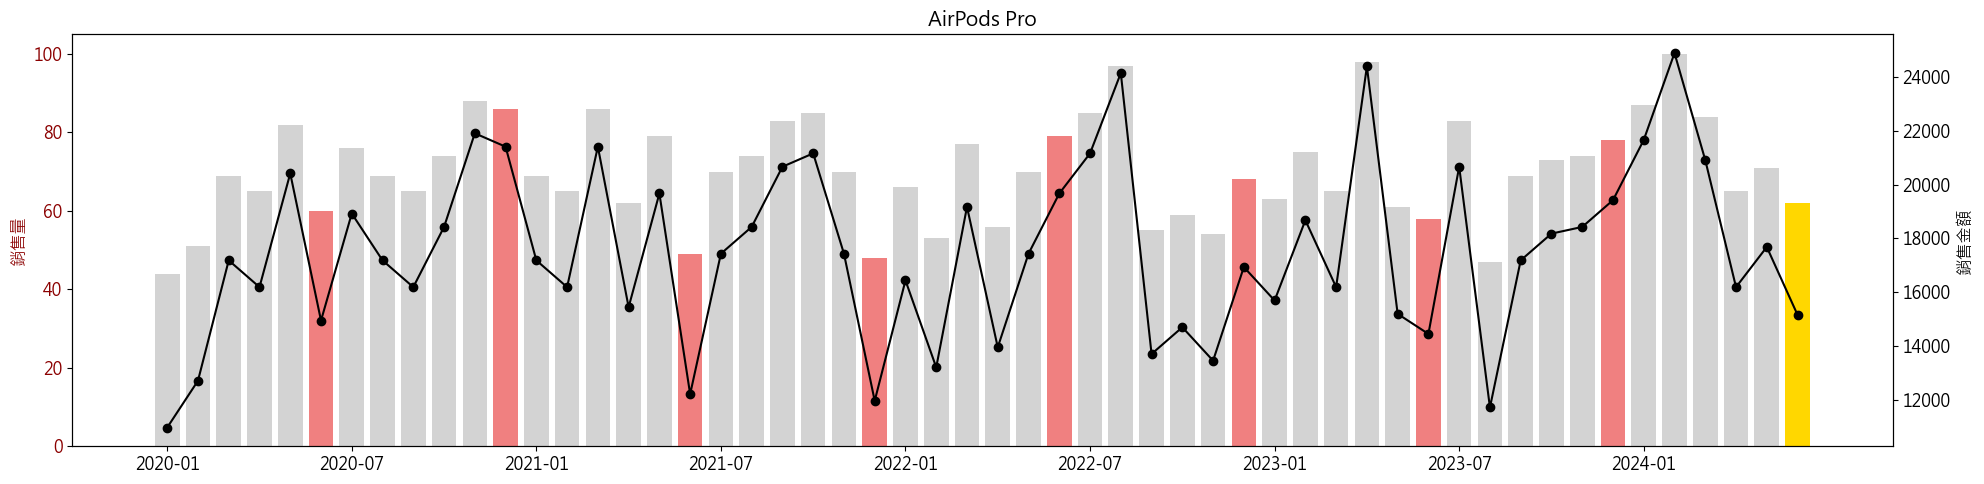
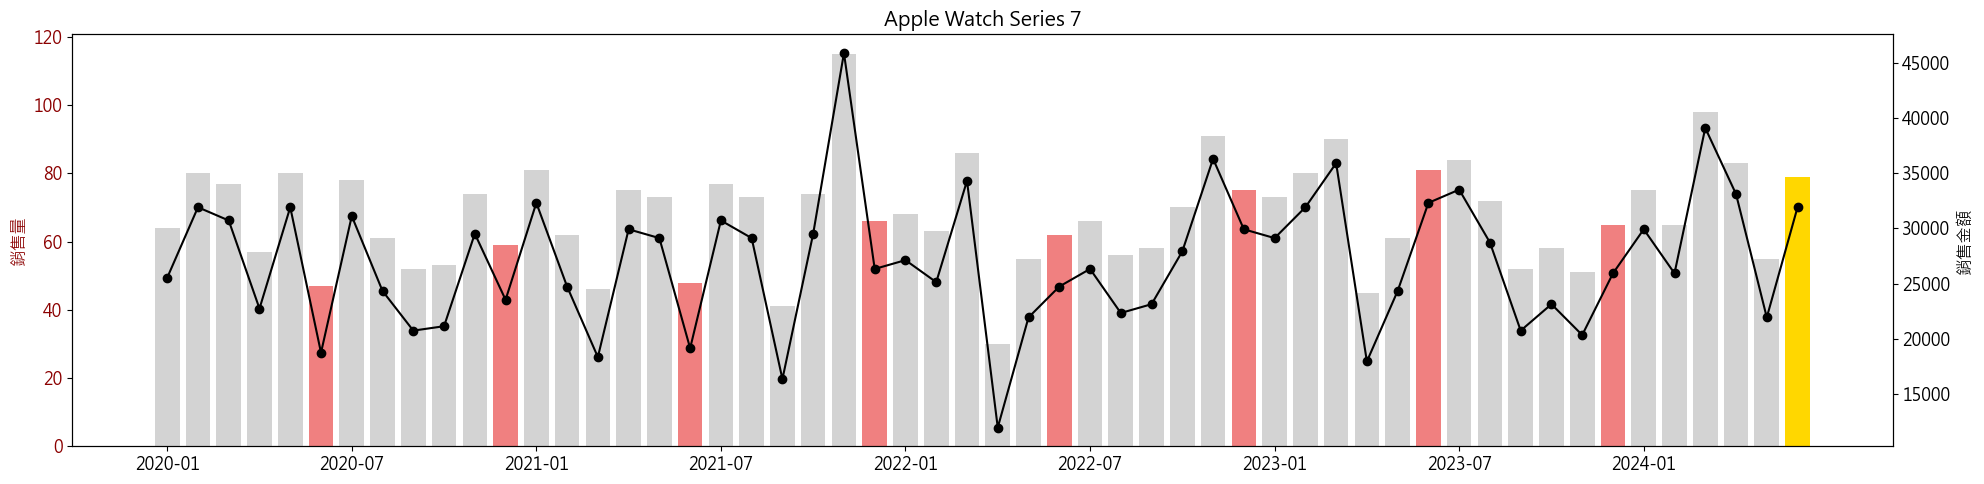
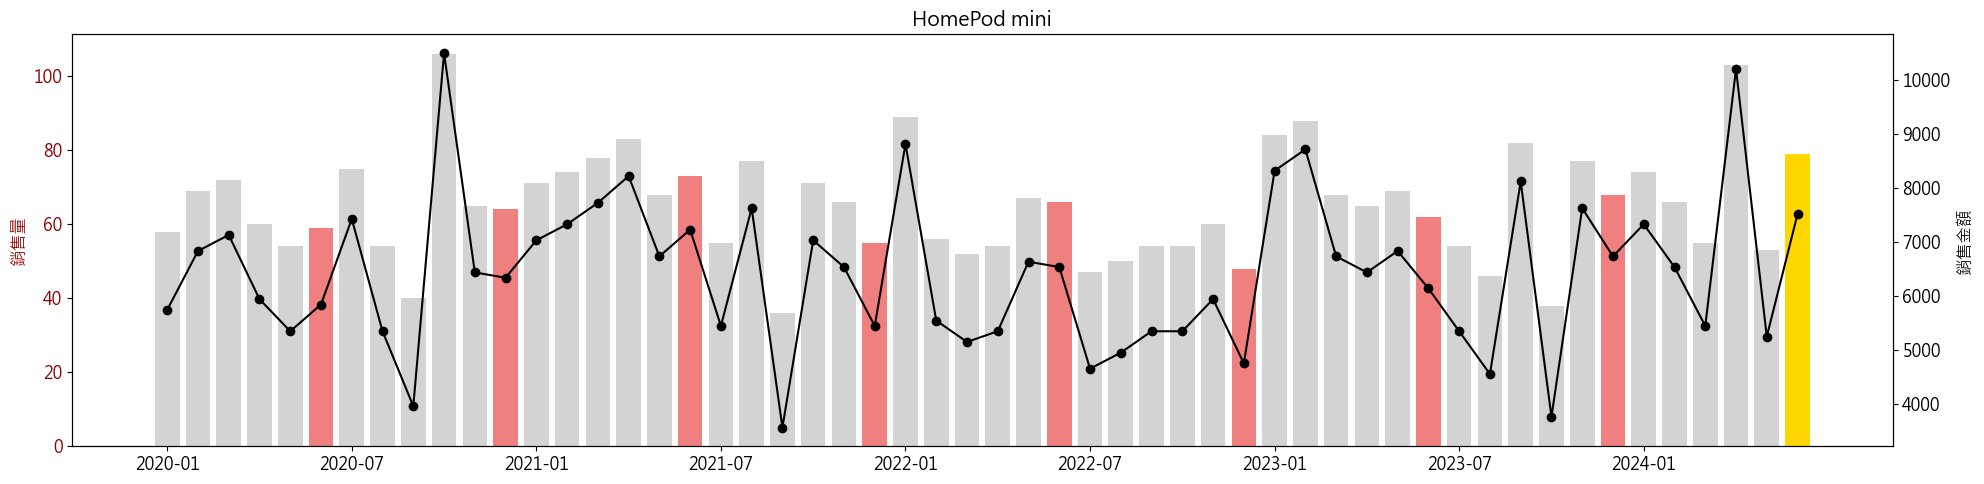
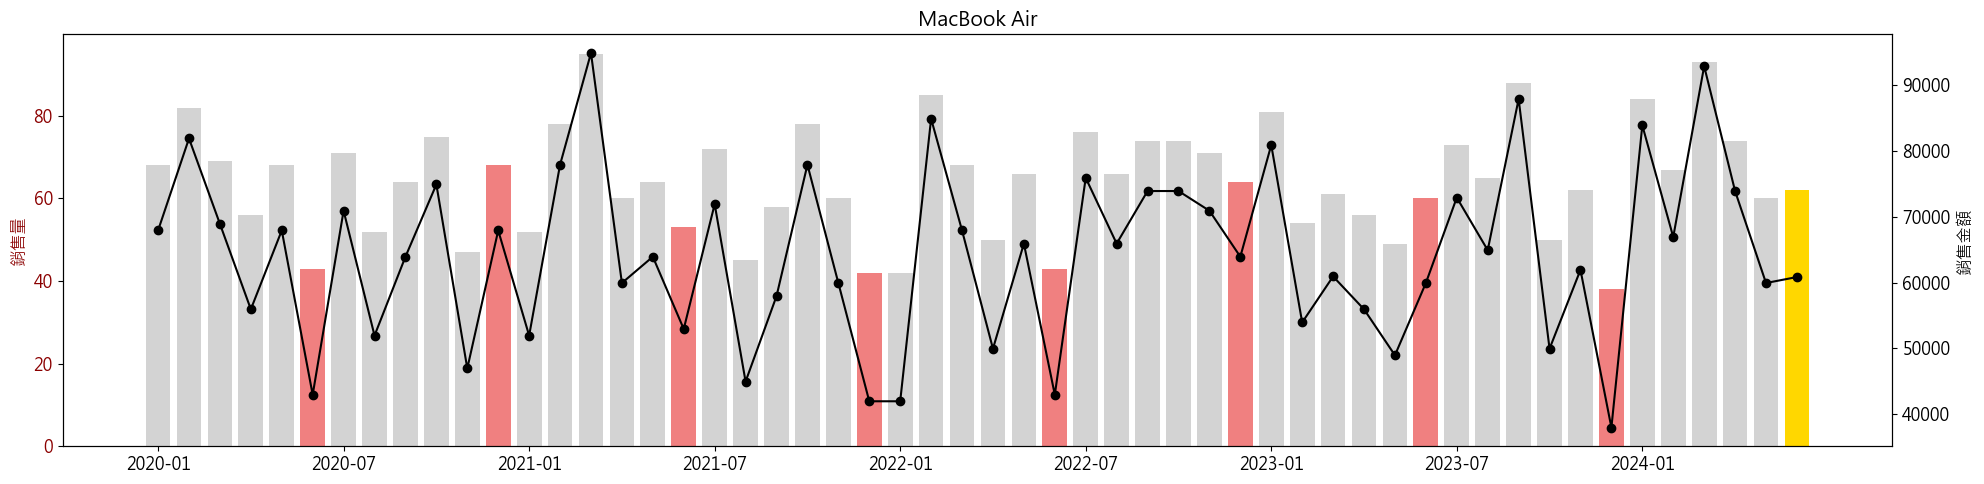
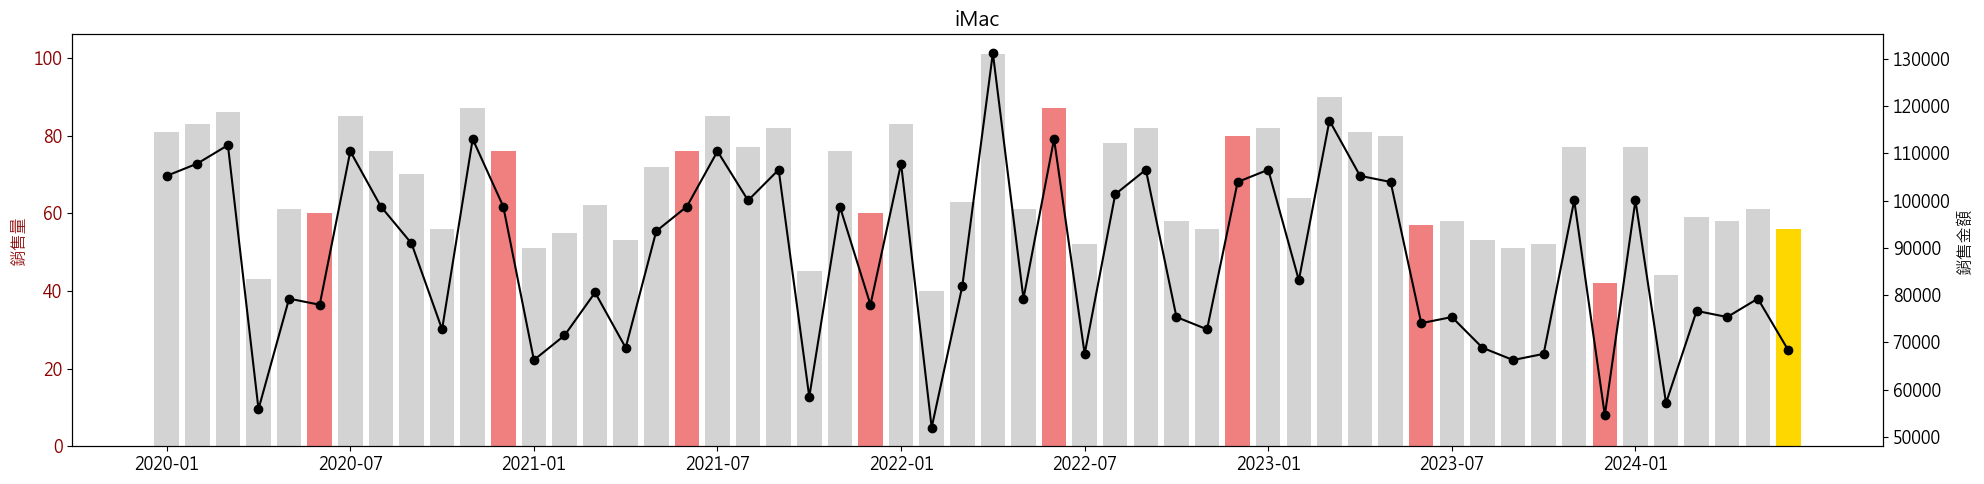
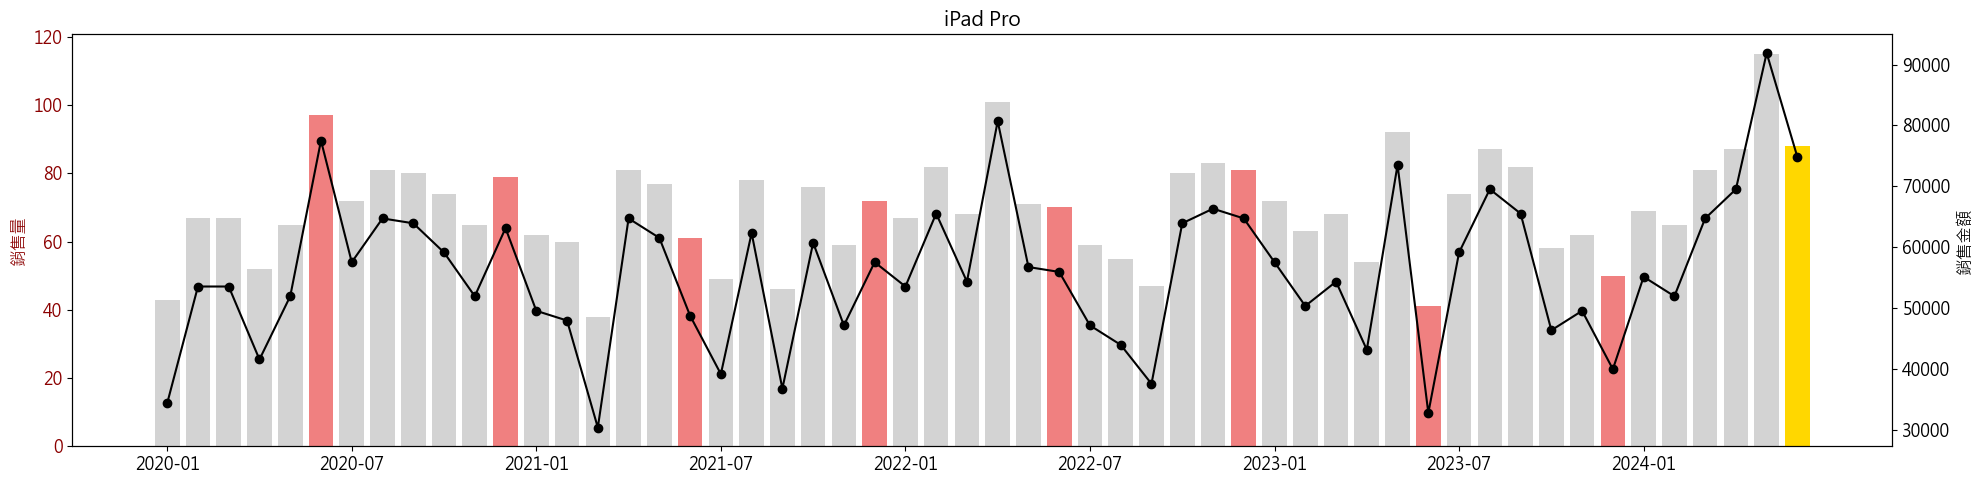
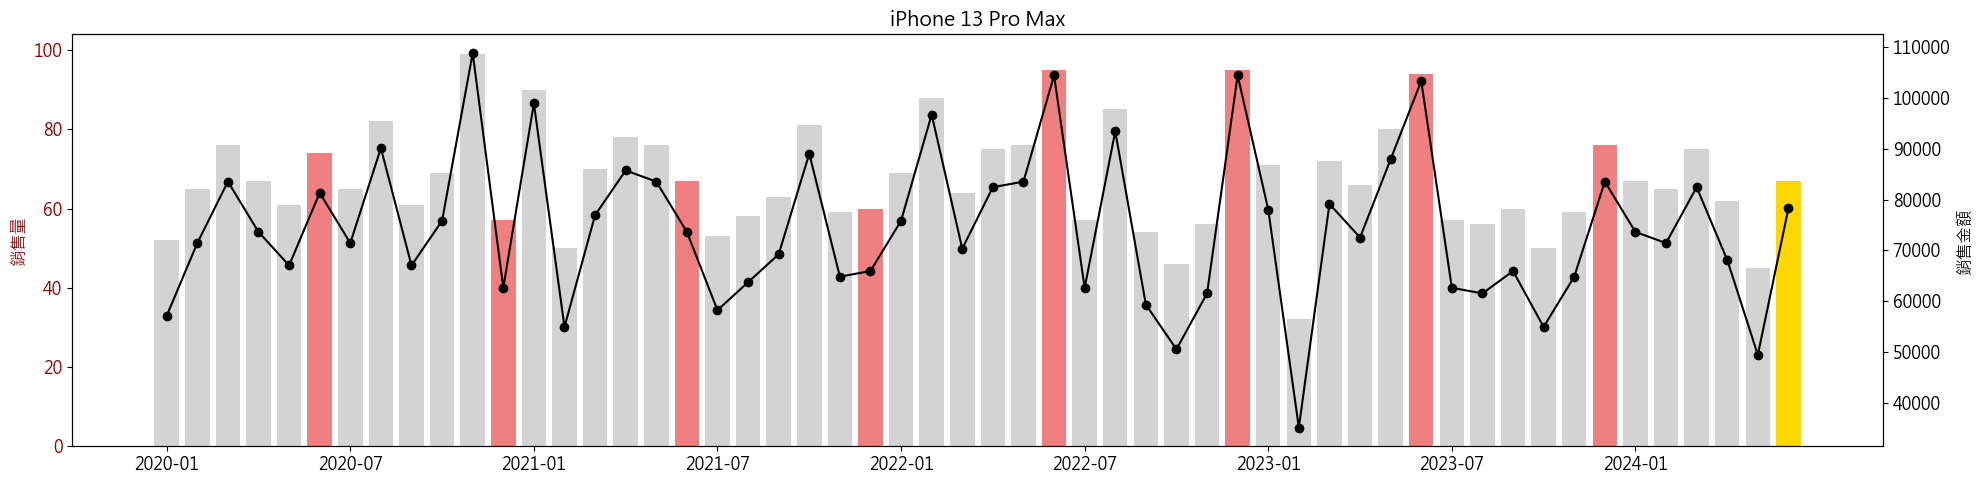

In [16]:
# 確保日期與金額欄位正確
df_merged['PurchaseDate'] = pd.to_datetime(df_merged['PurchaseDate'])
df_merged['TotalPrice'] = df_merged['Quantity'] * df_merged['Price']

# 建立「年月」欄位（格式：2023-06）
df_merged['YearMonth'] = df_merged['PurchaseDate'].dt.to_period('M')

# 分組統計：每個產品每月的銷售量與銷售金額
df_product_monthly = df_merged.groupby(['ProductName', 'YearMonth']).agg(
    MonthlyQuantity=('Quantity', 'sum'),
    MonthlyRevenue=('TotalPrice', 'sum')
).reset_index()

df_product_monthly

,ProductName,YearMonth,MonthlyQuantity,MonthlyRevenue
0,AirPods Pro,2020-01,44,10956.0
1,AirPods Pro,2020-02,51,12699.0
2,AirPods Pro,2020-03,69,17181.0
3,AirPods Pro,2020-04,65,16185.0
4,AirPods Pro,2020-05,82,20418.0
...,...,...,...,...
372,iPhone 13 Pro Max,2024-02,65,71435.0
373,iPhone 13 Pro Max,2024-03,75,82425.0
374,iPhone 13 Pro Max,2024-04,62,68138.0
375,iPhone 13 Pro Max,2024-05,45,49455.0


In [17]:
# 踢掉 2024-06 資料
df = df_product_monthly[df_product_monthly['YearMonth'] != '2024-06']

# 取得產品清單
product_list = df['ProductName'].unique()

df

,ProductName,YearMonth,MonthlyQuantity,MonthlyRevenue
0,AirPods Pro,2020-01,44,10956.0
1,AirPods Pro,2020-02,51,12699.0
2,AirPods Pro,2020-03,69,17181.0
3,AirPods Pro,2020-04,65,16185.0
4,AirPods Pro,2020-05,82,20418.0
...,...,...,...,...
371,iPhone 13 Pro Max,2024-01,67,73633.0
372,iPhone 13 Pro Max,2024-02,65,71435.0
373,iPhone 13 Pro Max,2024-03,75,82425.0
374,iPhone 13 Pro Max,2024-04,62,68138.0


In [18]:
#SARIMAX 考慮季節性

forecast_list = []

for product in product_list:
    df_target = df[df['ProductName'] == product].copy()

    # 轉 datetime index
    df_target['YearMonth'] = df_target['YearMonth'].astype(str)
    df_target['YearMonth'] = pd.to_datetime(df_target['YearMonth'])
    df_target.set_index('YearMonth', inplace=True)
    df_target = df_target.asfreq('MS')  # MS: 每月起始點

    # 模型建立與訓練（預測銷售量）銷售有穩定趨勢
    result_q = SARIMAX(df_target['MonthlyQuantity'], order=(1,1,0), seasonal_order=(1,1,1,6), enforce_stationarity=False).fit()
    result_r = SARIMAX(df_target['MonthlyRevenue'], order=(1,1,0), seasonal_order=(1,1,1,6), enforce_stationarity=False).fit()

    # 預測下一期（1 個月）
    forecast_q = result_q.forecast(steps=1)
    forecast_r = result_r.forecast(steps=1)
    forecast_list.append({
    'ProductName': product,
    'ForecastMonth': '2024-06',
    'ForecastQuantity': round(forecast_q.values[0]),
    'ForecastRevenue': round(forecast_r.values[0])
    })

df_forecast = pd.DataFrame(forecast_list).sort_values(by='ForecastQuantity')
df_forecast

,ProductName,ForecastMonth,ForecastQuantity,ForecastRevenue
4,iMac,2024-06,56,68271
0,AirPods Pro,2024-06,62,15152
3,MacBook Air,2024-06,62,60848
6,iPhone 13 Pro Max,2024-06,67,78278
2,HomePod mini,2024-06,79,7514
1,Apple Watch Series 7,2024-06,79,31922
5,iPad Pro,2024-06,88,74777


In [19]:
# ols
forecast_ols = []

for product in product_list:
    df_p = df[df['ProductName'] == product].copy()
    df_p = df_p.sort_values('YearMonth')

    # 建立 MonthIndex
    df_p['MonthIndex'] = range(len(df_p))

    # 準備訓練資料
    X_qty = sm.add_constant(df_p[['MonthIndex']])  # 保證是 DataFrame，欄位為 ['const', 'MonthIndex']
    y_qty = df_p['MonthlyQuantity']
    model_qty = sm.OLS(y_qty, X_qty).fit()

    # 預測下一期
    next_index = len(df_p)

    # 這裡手動建立與 X_qty 相同欄位順序的 DataFrame
    X_next = pd.DataFrame([{
        'const': 1,                # 截距項
        'MonthIndex': next_index  # 下一個月對應的時間索引
    }]) 

    # 預測
    forecast_qty = model_qty.predict(X_next)[0]

    # ----------- 預測「銷售金額」 -----------
    y_rev = df_p['MonthlyRevenue']
    model_rev = sm.OLS(y_rev, X_qty).fit()
    forecast_rev = model_rev.predict(X_next)[0]

    forecast_ols.append({
        'ProductName': product,
        'ForecastMonth': '2024-06',
        'ForecastQuantity': round(forecast_qty),
        'ForecastRevenue': round(forecast_rev)
    })

# 結果轉成 DataFrame
df_forecast_ols = pd.DataFrame(forecast_ols).sort_values(by='ForecastQuantity')
df_forecast_ols

,ProductName,ForecastMonth,ForecastQuantity,ForecastRevenue
4,iMac,2024-06,62,81037
2,HomePod mini,2024-06,64,6381
6,iPhone 13 Pro Max,2024-06,64,70777
3,MacBook Air,2024-06,66,66060
1,Apple Watch Series 7,2024-06,70,27979
5,iPad Pro,2024-06,74,59283
0,AirPods Pro,2024-06,75,18594


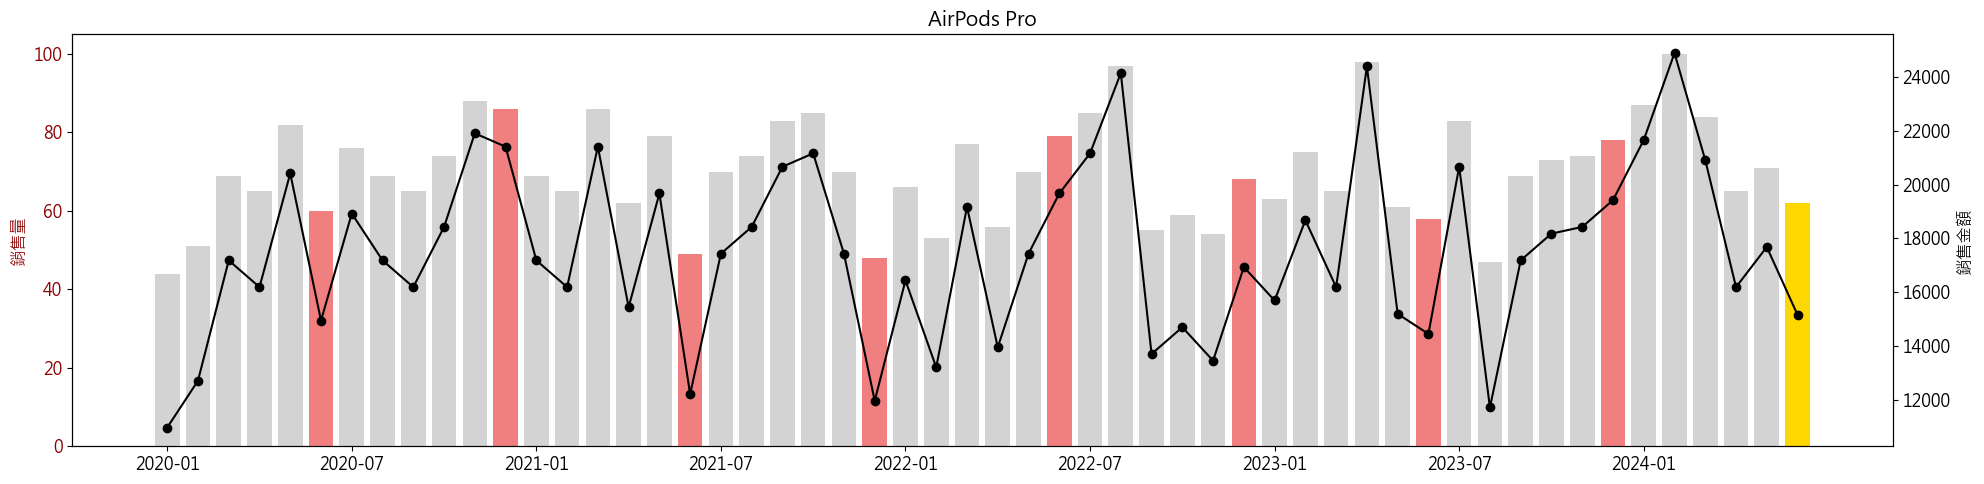

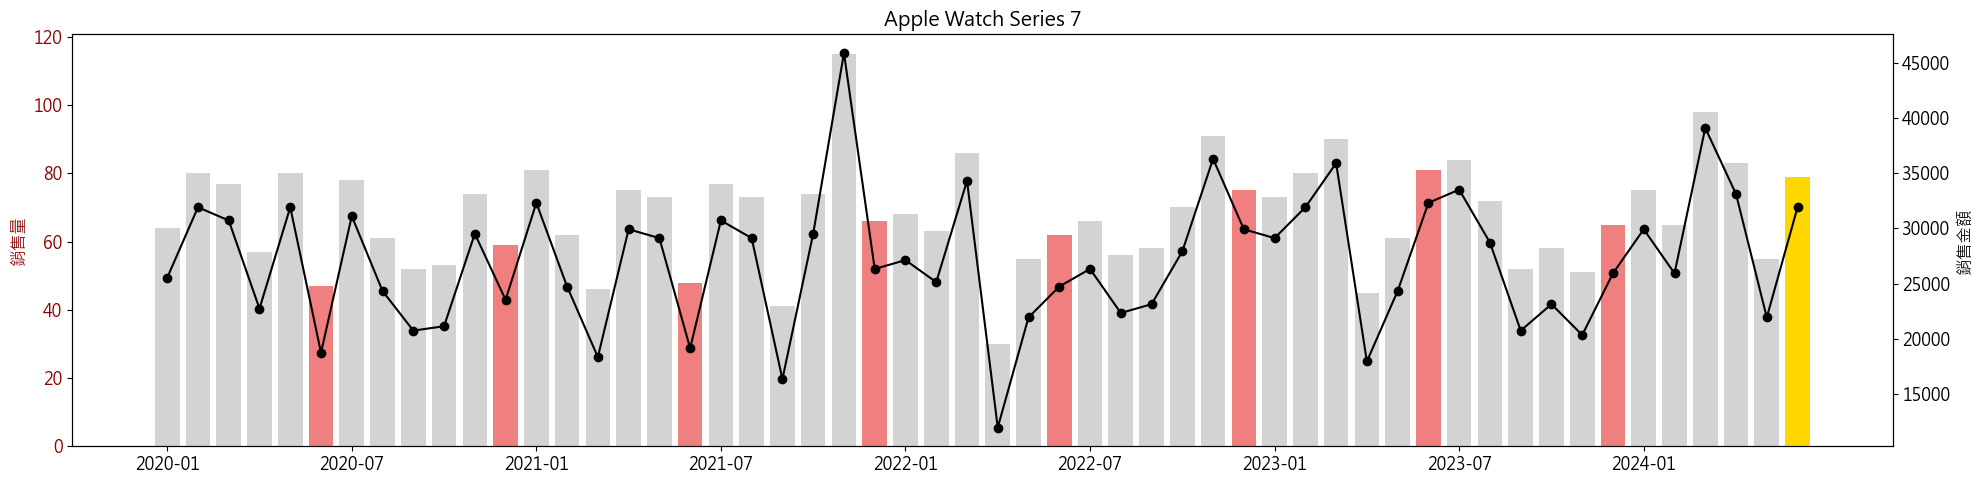

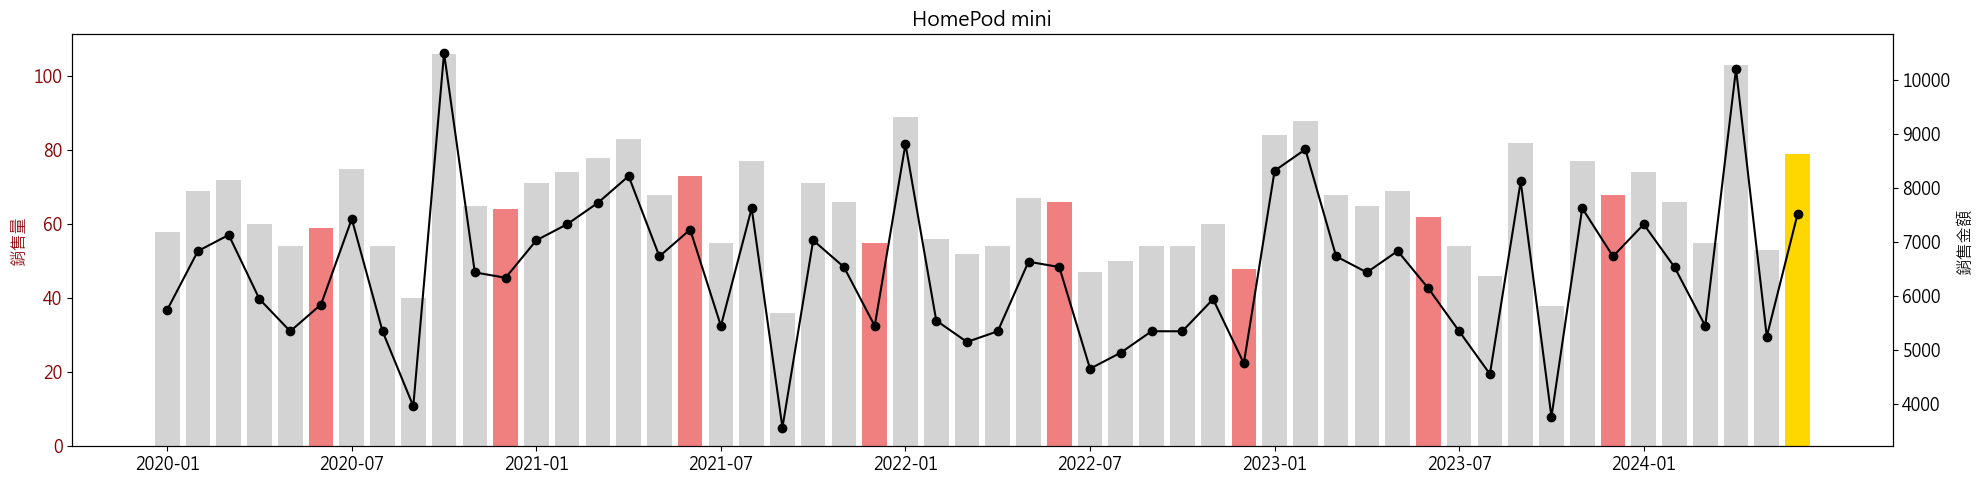

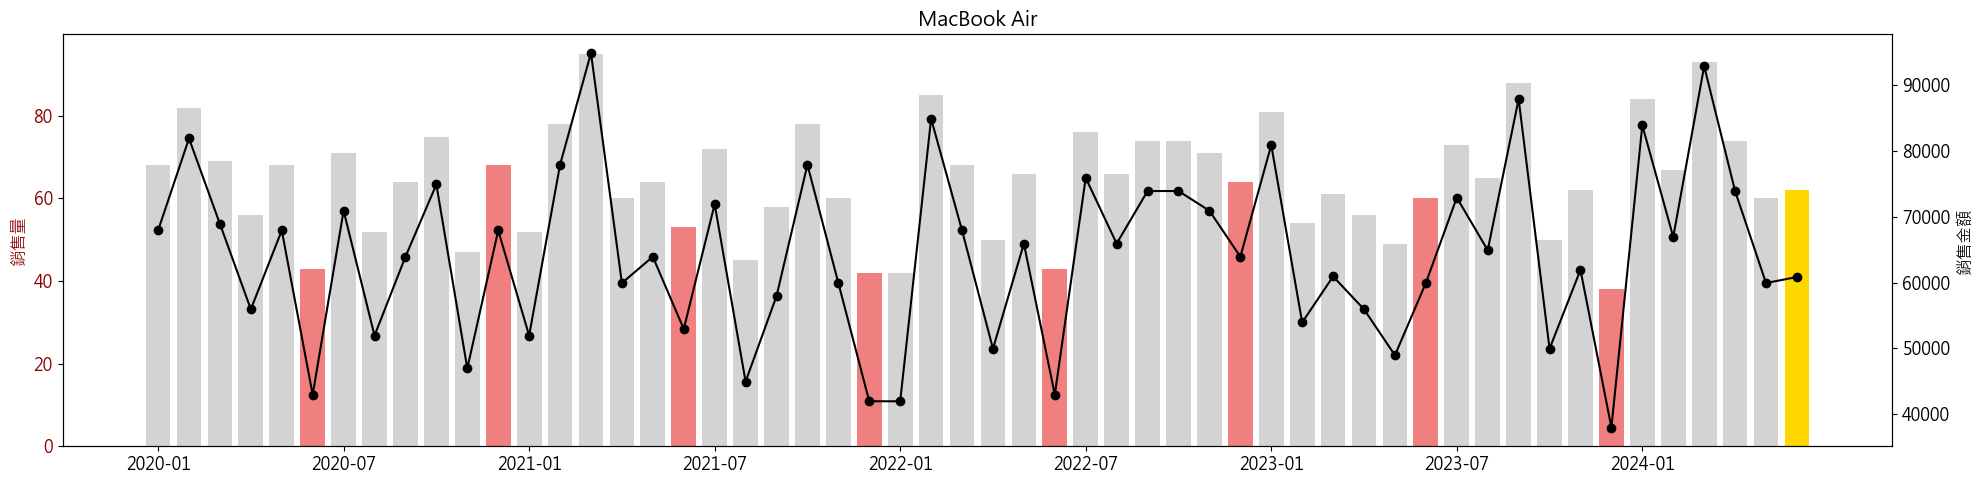

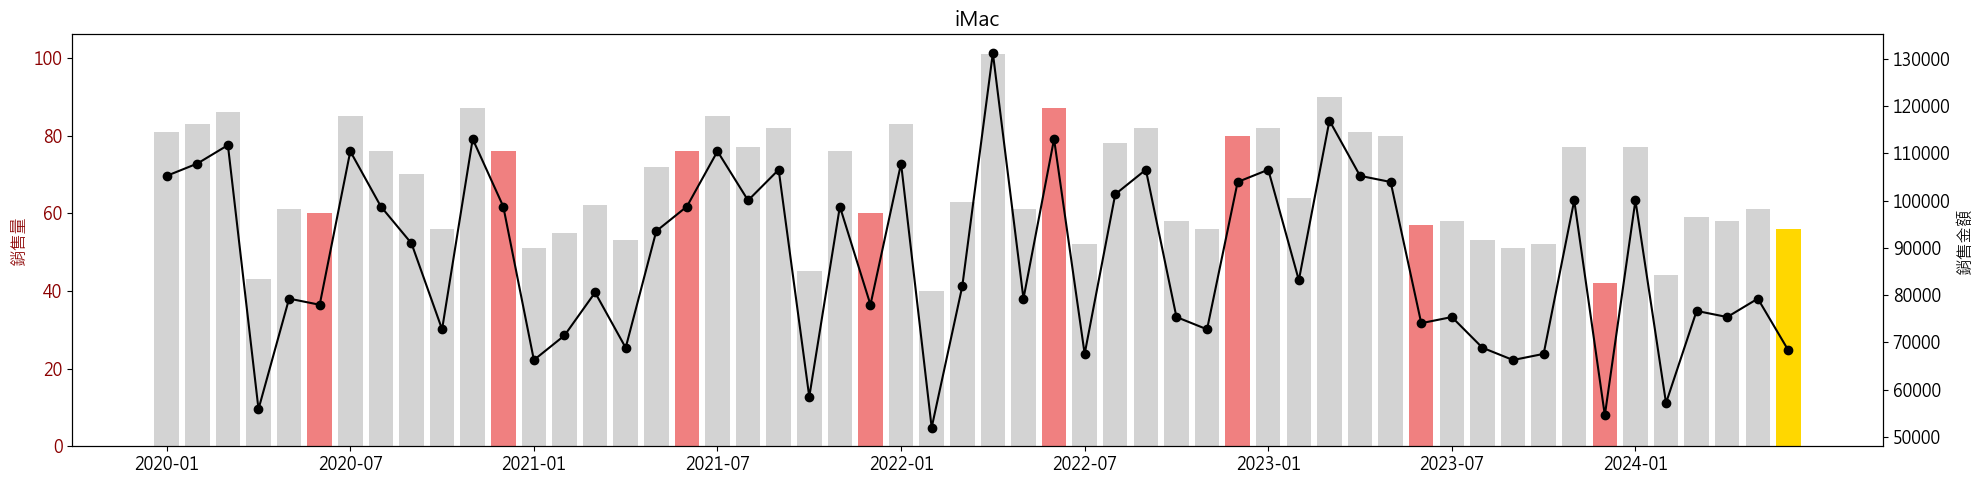

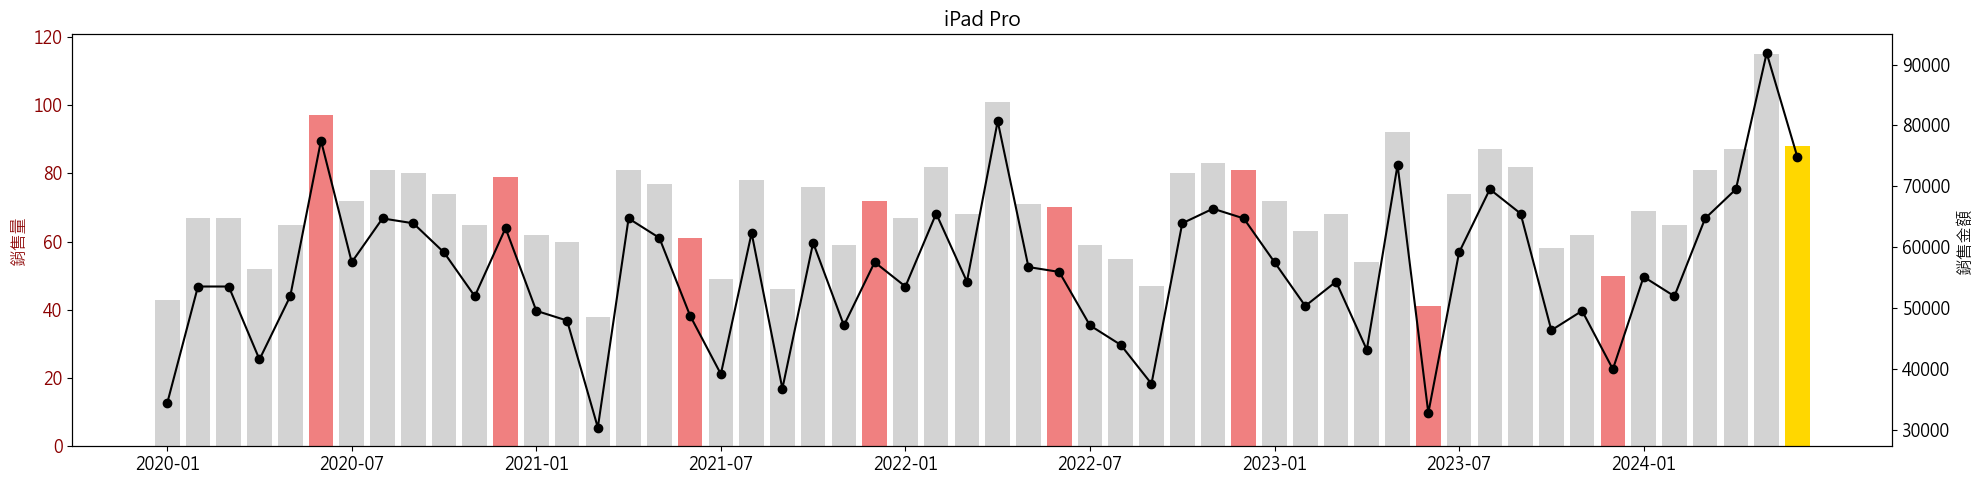

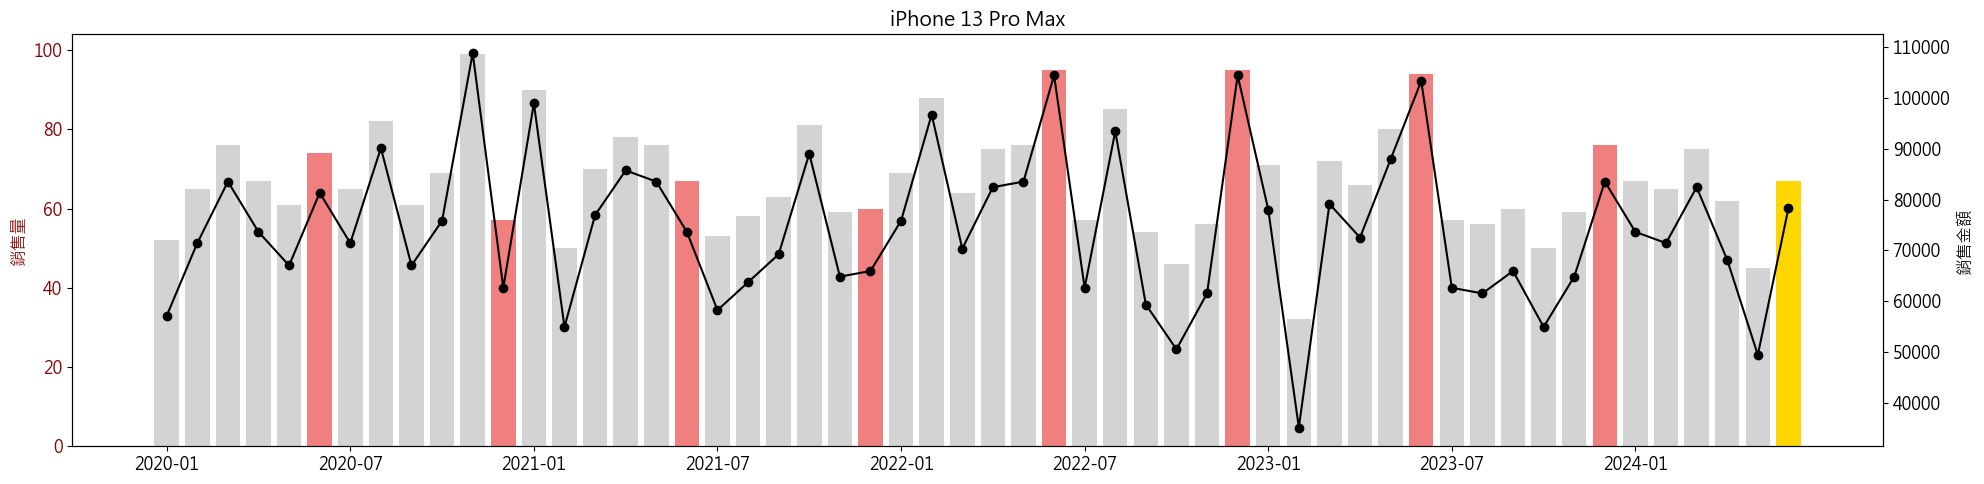

In [20]:
# SARIMAX 逐個產品畫雙軸圖
for product in product_list:
    df_p = df[df['ProductName'] == product]

    # 看有沒有該產品的預測
    if product in df_forecast['ProductName'].values:
        pred = df_forecast[df_forecast['ProductName'] == product].iloc[0]
        # 新增一列預測資料
        new_row = pd.DataFrame([{
            'ProductName': product,
            'YearMonth': pd.to_datetime(pred['ForecastMonth']),
            'MonthlyQuantity': pred['ForecastQuantity'],
            'MonthlyRevenue': pred['ForecastRevenue']
        }])
        df_p = pd.concat([df_p, new_row], ignore_index=True)

    # X 軸為月份
    x = df_p['YearMonth'].astype(str)
    

    # 準備顏色清單
    bar_colors = ['lightcoral', 'lightgrey']  # 可自訂多色

    bar_colors = [bar_colors[0] if (i + 1) % 6 == 0 else bar_colors[1] for i in range(len(x))]
    
    # 最後一根條改成黃色（預測值）
    if product in df_forecast['ProductName'].values:
        bar_colors[-1] = 'gold'

    # 畫圖邏輯
    fig, ax1 = plt.subplots(figsize=(20, 5))
    ax2 = ax1.twinx()
    ax2.plot(x, df_p['MonthlyRevenue'], color='black', marker='o', label='金額')
    ax1.bar(x, df_p['MonthlyQuantity'], color=bar_colors, label='數量')

    ax2.set_ylabel('銷售金額', color='black')
    ax1.set_ylabel('銷售量', color='darkred')
    
    ax1.set_title(product)

    ax2.tick_params(axis='y', labelcolor='black') 
    ax1.tick_params(axis='y', labelcolor='darkred') 

    # 每三個月顯示一次 X 軸刻度
    ax1.set_xticks(x[::6])                    
    ax1.set_xticklabels(x[::6], rotation=0) 

    plt.tight_layout()
    plt.show()